<a href="https://colab.research.google.com/github/Yuji-github/DeepLabV3-TensorFlow/blob/main/DeepLabv3%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import glob, os
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/DeepLab/

/content/drive/MyDrive/DeepLab


For Data Loading

In [ ]:
def read_image(path): 
  path = path.decode()  # without this, image is encoded
  image = cv2.imread(path, cv2.IMREAD_COLOR)
  image = image / 255.0 # normalization 
  image = cv2.resize(image, (128, 128)) # resize to 128x128   
  image = image.astype(np.float32) # (128, 128, 3)

  return image

In [ ]:
def read_mask(path): 
  path = path.decode()  # without this, image is encoded
  mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE) # (128, 128)
  mask = mask / 255.0 # normalization 
  mask = cv2.resize(mask, (128, 128)) # resize to 128x128  
  mask = mask.astype(np.float32)
  mask = np.expand_dims(mask, axis=-1) # (128, 128, 1)  
  
  return mask

In [ ]:
def preprocess(image, mask): # map calls this function

  def f(image, mask): # preprocess calls this function
    
    image = read_image(image) # params -> /content/drive/MyDrive/DeepLab/images/***.png 
    mask = read_mask(mask)
    
    return image, mask

  images, masks = tf.numpy_function(f, [image, mask], [tf.float32, tf.float32])
  images.set_shape([128, 128, 3]) # must match the first layer in deeplab
  masks.set_shape([128, 128, 1]) # must match the last layer in deeplab

  return  images, masks

In [ ]:
def tf_dataset(image, mask, batch=2): # default batch is 8
  dataset = tf.data.Dataset.from_tensor_slices((image, mask))
  dataset = dataset.map(preprocess) # map needs function
  dataset = dataset.batch(batch)
  dataset = dataset.prefetch(10)

  return dataset

In [ ]:
def data_load():
  IMAGE_DIR = 'images'
  MASK_DIR = 'masks'

  imageList = []
  maskList = []

  for dirname, _, filenames in os.walk(IMAGE_DIR):
      for filename in filenames:
            imageList.append(os.path.join(dirname, filename))

  for dirname, _, filenames in os.walk(MASK_DIR):
      for filename in filenames:
            maskList.append(os.path.join(dirname, filename))

  imageList.sort() 
  maskList.sort()

  dataset = tf_dataset(imageList, maskList, 8) # retunr is (16, 128, 128, 3) (16, 128, 128, 1)

  return dataset

In [ ]:
def val_data_load(): # val dataset has 16 images
  IMAGE_DIR = 'val_images'
  MASK_DIR = 'val_masks'

  val_imageList = []
  val_maskList = []

  for dirname, _, filenames in os.walk(IMAGE_DIR):
      for filename in filenames:
            val_imageList.append(os.path.join(dirname, filename))

  for dirname, _, filenames in os.walk(MASK_DIR):
      for filename in filenames:
            val_maskList.append(os.path.join(dirname, filename))

  val_imageList.sort() 
  val_maskList.sort()

  val_dataset = tf_dataset(val_imageList, val_maskList, 8) # retunr is (8, 128, 128, 3) (8, 128, 128, 1)

  return val_dataset

DeepLabV3+

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Concatenate, UpSampling2D, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.data import Dataset, AUTOTUNE
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split

In [ ]:
def backbone(input_shape): 
  i= Input(input_shape)

  backbone = ResNet50(include_top=False, input_tensor=i) # when you have a tensor that you want to be the input.
  
  return (i, backbone.get_layer('conv4_block6_out').output, backbone.get_layer('conv2_block3_out').output)  # the last Resnet for encoding, other's for decoding layers are going back 

In [ ]:
def ASPP(input_shape): 

  pool_size = (input_shape.shape[1], input_shape.shape[2]) # assume (8, 8)
  # ASPP Part

  # --- Image Pooling ----
  image_pool = AveragePooling2D(pool_size)(input_shape) # after this layer: (None, 1, 1, 2048)
  image_pool = Conv2D(128, (1,1), padding='same', use_bias=False)(image_pool)
  image_pool = BatchNormalization()(image_pool)
  iamge_pool = Activation('relu')(image_pool) # after this layer: (None, 1, 1, 128)
  image_pool = UpSampling2D(pool_size, interpolation='bilinear')(iamge_pool) # after this layer: (None, 8, 8, 128)

  # --- 1x1 Conv ----
  one = Conv2D(128, (1,1), padding='same', use_bias=False)(input_shape)
  one = BatchNormalization()(one)
  one = Activation('relu')(one) # after this layer: (None, 8, 8, 128)

  # --- 3x3 Conv Rate 6 ----
  rate_6 = Conv2D(128, (3,3), padding='same', use_bias=False, dilation_rate=6)(input_shape) # dilation_rate = 6 is key step 
  rate_6 = BatchNormalization()(rate_6)
  rate_6 = Activation('relu')(rate_6) # after this layer: (None, 8, 8, 128)

  # --- 3x3 Conv Rate 12 ----
  rate_12 = Conv2D(128, (3,3), padding='same', use_bias=False, dilation_rate=12)(input_shape) # dilation_rate = 12 is key step 
  rate_12 = BatchNormalization()(rate_12)
  rate_12 = Activation('relu')(rate_12) # after this layer: (None, 8, 8, 128)

  # --- 3x3 Conv Rate 18 ----
  rate_18 = Conv2D(128, (3,3), padding='same', use_bias=False, dilation_rate=18)(input_shape) # dilation_rate = 18 is key step 
  rate_18 = BatchNormalization()(rate_18)
  rate_18 = Activation('relu')(rate_18) # after this layer: (None, 8, 8, 128)


  # After ASPP Part  
  # --- Concatenate ---- *Make Sure all sizes are the same before Concatenation
  aspp = Concatenate()([image_pool, one, rate_6, rate_12, rate_18]) # after this layer: (None, 8, 8, 640) 640 from 128 feature each * 5
  
  # --- 1x1 Conv for UpSamling ----
  for_up = Conv2D(128, (1,1), padding='same', use_bias=False)(aspp)
  for_up = BatchNormalization()(for_up)
  for_up = Activation('relu')(for_up) # after this layer: (None, 8, 8, 128)

  return for_up

In [ ]:
def decoding(input_shape):  
  decode_one = Conv2D(32, (1,1), padding='same', use_bias=False)(input_shape) # *output features are arbitrary
  decode_one = BatchNormalization()(decode_one)
  decode_one = Activation('relu')(decode_one) # after this layer: (None, 32, 32, 64)

  return decode_one

In [ ]:
def deeplabv3(input_shape):
  # step1: get input shape of images
  i = input_shape # suppose layer shape is (128, 128, 3)

  # --- Encoding Section ----

  # step2: through backbone (Resnet50)
  # we can replace this backbone ResNeSt in the future 

  i, encode_layer, decode_layer = backbone(i) # retun shapes: encode (None, 8, 8, 1024), decode (None, 32, 32, 256)

  # step3: pass the encode_layer to ASPP 
  end_encoding_layer = ASPP(encode_layer)  
   
  # step3-2: UpSamling for Concatenation 
  end_encoding_layer = UpSampling2D((4, 4), interpolation='bilinear')(end_encoding_layer) # after this layer: (None, 32, 32, 128) 


  # --- Decoding Section ---- need to get the same shape from ResNet (None, 32, 32, 256)

  # step4: Decoding and Concatenating  
  decode_one = decoding(decode_layer) 

  # step5: Concatenation 
  mix_layer = Concatenate()([end_encoding_layer, decode_one]) # after this layer: (None, 32, 32, 320)


  # --- Prepare Output Section ---- 
  # step6: 3x3 Conv (at least 1 block needs *output features are arbitrary)
  three = Conv2D(128, (3,3), padding='same', use_bias=False)(mix_layer) # for 256 Conv2D(256, (3,3),
  three = BatchNormalization()(three)
  three = Activation('relu')(three)

  three = Conv2D(128, (3,3), padding='same', use_bias=False)(three) # for 256 Conv2D(512, (3,3),
  three = BatchNormalization()(three)
  three = Activation('relu')(three) # after this layer (None, 32, 32, 512)

  # step7: end of Deeplabv3 make sure out put size is the same as input size
  end_layer = UpSampling2D((4, 4), interpolation='bilinear')(three) # after this layer (None, 128, 128, 512)

  # --- Output Section ---- 
  output = Conv2D(1, (1,1))(end_layer)
  output = Activation('sigmoid')(output) # (None, 128, 128, 1)
  
  # model summary and compile
  return Model(i, output)

Loss Function for Semantic Segmentation
https://www.youtube.com/watch?v=AZr64OxshLo&t=785s More Info

In [ ]:
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

In [ ]:
def dice_coef(y_true, y_pred):
    smooth = 1e-15
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [ ]:
def dice_loss(y_true, y_pred): 
  # this part is dice_coef
  # y_true = tf.cast(y_true, tf.float32)
  # y_pred = tf.math.sigmoid(y_pred)

  # numerator = 2 * tf.reduce_sum(y_true * y_pred)
  # denominator = tf.reduce_sum(y_true + y_pred)

  # must be 1 - dice_coef for backpropagation
  return 1 - dice_coef(y_true, y_pred) # 1- numerator/denominator

Call Back

In [ ]:
def lr_decay(epoch):
    initial_learningrate=2e-3
    if epoch < 2:
        return initial_learningrate
    else:
        return initial_learningrate * 0.99 ** epoch

Prediction (Vizulaization)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


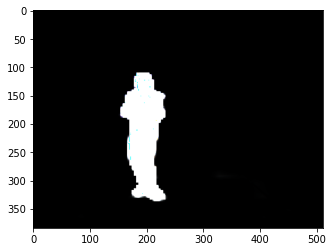

In [54]:
path = '/content/drive/MyDrive/DeepLab/test_iamge/HipHop_HipHop1_C0_00180.png'

""" Getting an image """
image = cv2.imread(path, cv2.IMREAD_COLOR)
h, w, _ = image.shape # to back to the original size (predict_mask)
x = cv2.resize(image, (128, 128))
x = x/255.0 # normalization values are 0-1
x = x.astype(np.float32)
x = np.expand_dims(x, axis=0) # (1, 128, 128, 3)

""" Prediction the mask """
y = deeplab.predict(x)[0] # (128, 128, 1) [0]-> drop off the first dim, this case 1
y = cv2.resize(y, (w, h)) # (384, 512)
y = np.expand_dims(y, axis=-1) # (384, 512, 1) to plot the image
masked_image = image * y # must do this part to get back the values
plt.imshow(masked_image)

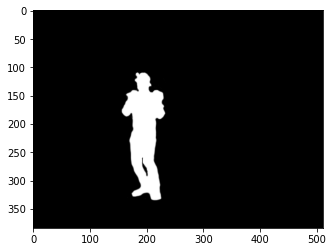

In [ ]:
t = '/content/drive/MyDrive/DeepLab/test_mask/HipHop_HipHop1_C0_00180.png'
t_image = cv2.imread(t)
plt.imshow(t_image)

In [ ]:
if __name__ == "__main__":

 # -- Data Loading Section ---  
 dataset = data_load() # get 128x128 images (numpy, values[pixels] are between 0-1)
 val_data = val_data_load()

 # -- Building Model Section --- 
 i = (128, 128, 3) 
 deeplab = deeplabv3(i)

 # --- Compile Section ---- binary_entrophy is okay as masks are black and white, but not suitable 
 deeplab.compile(optimizer=Adam(), loss=dice_loss, metrics=[dice_coef, iou])

 # print(deeplab.summary()) # check neural networks  

 # --- Training Section ---
 model_callback = [
        LearningRateScheduler(lr_decay, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        ]

 deeplab.fit(dataset,
            validation_data=val_data,
            epochs=20, 
            callbacks=model_callback)
 
 deeplab.save('/content/drive/MyDrive/DeepLab/output/model.h5') 
 # --- Evaluation Section ---

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.002.
145/145 [==============================] - 40s 230ms/step - loss: 0.2909 - dice_coef: 0.7091 - iou: 0.5708 - val_loss: 1.0000 - val_dice_coef: 3.7800e-06 - val_iou: 1.8900e-06
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.002.
145/145 [==============================] - 32s 222ms/step - loss: 0.1651 - dice_coef: 0.8349 - iou: 0.7184 - val_loss: 1.0000 - val_dice_coef: 9.0493e-06 - val_iou: 4.5247e-06
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.0019602.
145/145 [==============================] - 33s 223ms/step - loss: 0.1315 - dice_coef: 0.8685 - iou: 0.7683 - val_loss: 1.0000 - val_dice_coef: 9.3110e-07 - val_iou: 4.6555e-07
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.0019405980000000002.
145/145 [==============================] - 33s 223ms/step - loss: 0.1164 - dice_coef: 0.8836 - iou: 0.7921 - val_loss: 1.0000 - val_dice

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
